# PROCESAMIENTO DE IMAGENES DE FLORES

El siguiente código realizado en Python se ha diseñado y modificado en base al proyecto de [SAM_gDINO_AutoLabeling](https://github.com/mhyeonsoo/SAM_gDINO_AutoLabeling.git), que a su vez se basa en [Grounded-Segment-Anything](https://github.com/IDEA-Research/Grounded-Segment-Anything.git) que usa [GroundingDINO](https://github.com/IDEA-Research/GroundingDINO.git) y [SAM (Segment Anything) ](https://github.com/facebookresearch/segment-anything.git).

## Índice
1. [Preparación del entorno de trabajo](#preparación-del-entorno-de-trabajo)
2. [Utilidades de Carga y Preprocesamiento de Datos](#utilidades-de-carga-y-preprocesamiento-de-datos)
3. [Proceso de segmentacion y generacion de anotaciones](#segmentacion-generacion-anotaciones)

## Preparación del entorno de trabajo<a name="preparación-del-entorno-de-trabajo"></a>

### Instalación de bibliotecas y paquetes

Instala la biblioteca "segment-anything" de Facebook Research desde su repositorio de GitHub utilizando el comando `pip`.

In [ ]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


### Clonación del repositorio Grounded-Segment-Anything y configuración de GroundingDINO

Cambia el directorio de trabajo actual a "/content" en el entorno de ejecución de Google Colab.

In [ ]:
%cd /content

/content


Clona el repositorio "Grounded-Segment-Anything" desde GitHub en el directorio actual de trabajo.

In [ ]:
!git clone --quiet https://github.com/IDEA-Research/Grounded-Segment-Anything

fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.


Cambia el directorio de trabajo actual al directorio recién clonado "Grounded-Segment-Anything".

In [ ]:
%cd /content/Grounded-Segment-Anything

/content/Grounded-Segment-Anything


Instala la biblioteca "GroundingDINO" desde el directorio "/content/Grounded-Segment-Anything/GroundingDINO" utilizando el comando `pip`.

In [ ]:
!pip install -q -e /content/Grounded-Segment-Anything/GroundingDINO

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for groundingdino (pyproject.toml) ... done


### Importación de bibliotecas

In [ ]:
import os, sys

sys.path.append(
    os.path.join(os.getcwd(), "/content/Grounded-Segment-Anything/GroundingDINO")
)

In [ ]:
# Importación de otras bibliotecas y módulos
import datetime

import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image

from PIL import Image
from huggingface_hub import hf_hub_download

In [ ]:
# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

In [ ]:
# segment anything
from segment_anything import build_sam, SamPredictor

In [ ]:
# torch transform
import torchvision.transforms as TT

### Configuración del dispositivo

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# Aviso si no se puede cargar las operaciones C++ personalizadas para GroundingDINO en GPU
if device != "cpu":
    try:
        from GroundingDINO.groundingdino import _C
    except:
        warnings.warn(
            "Failed to load custom C++ ops. Running on CPU mode Only in groundingdino!"
        )

### Descarga y carga del modelo Grounding DINO

Función para cargar el modelo de Grounding DINO desde Hugging Face Hub

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location="cpu")
    log = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    model.to(device)
    return model

Carga del modelo de Grounding DINO

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filename = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(
    ckpt_repo_id, ckpt_filename, ckpt_config_filename, device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### Descarga y carga del modelo SAM

Descarga del modelo SAM pre-entrenado

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-07-20 05:52:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   128MB/s    in 12s     

2024-07-20 05:52:33 (205 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



Construcción y configuración del modelo SAM

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

## Utilidades de Carga y Preprocesamiento de Datos<a name="utilidades-de-carga-y-preprocesamiento-de-datos"></a>

### Función `load_image`

Esta función carga una imagen desde una ruta de archivo especificada, la convierte a formato RGB y la procesa utilizando una serie de transformaciones, incluyendo un redimensionamiento aleatorio y normalización, antes de retornarla en formato tensor.

In [ ]:
def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

### Función `load_model`


Esta función carga un modelo pre-entrenado utilizando la configuración y el archivo de checkpoint proporcionados. Ajusta el modelo al dispositivo especificado y lo retorna en modo de evaluación.

In [ ]:
def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model

### Función `get_grounding_output`


Esta función toma un modelo de Grounding DINO, una imagen, una descripción textual y umbrales de confianza como entrada, y devuelve las regiones destacadas (boxes) y las frases asociadas con su localización en la imagen, filtradas según los umbrales proporcionados.

In [ ]:
def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

### Función `show_mask`


Esta función visualiza una máscara de segmentación en una figura de matplotlib. Si se especifica, la función puede asignar un color aleatorio a la máscara.

In [ ]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

### Función `show_box`

Esta función muestra un cuadro delimitador (bounding box) en una figura de matplotlib, con una etiqueta opcional asociada.

In [ ]:
def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0, label)

### Función `create_sub_mask_annotation`

Esta función crea anotaciones para sub-máscaras de una máscara de segmentación. Utiliza contornos para encontrar las líneas de borde alrededor de cada sub-máscara y calcula su área, bounding box y segmentación para su inclusión en las anotaciones.

In [ ]:
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Encontrar contornos alrededor de cada sub-máscara
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Convertir de (fila, columna) a (x, y) y restar el píxel de relleno
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Crear un polígono y simplificarlo
        poly = Polygon(contour)
        if not poly.is_valid:
            continue  # Saltar polígonos inválidos
        poly = poly.simplify(1.0, preserve_topology=False)
        if poly.is_empty:
            continue  # Saltar polígonos vacíos

        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    if not polygons:
        # Retornar None o un diccionario vacío si no hay polígonos válidos
        return None

    # Combinar los polígonos para calcular el cuadro delimitador y el área
    multi_poly = MultiPolygon(polygons)
    if multi_poly.is_empty:
        # Retornar None o un diccionario vacío si no hay polígonos válidos
        return None

    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area,
    }

    return annotation

### Función `create_image_info`

Esta función crea información de imágenes para el conjunto de datos. Define los metadatos básicos de una imagen, como su identificador, nombre de archivo, dimensiones, URL y fecha de captura.

In [ ]:
def create_image_info(image_id, file_name, image_size, colors,
                      date_captured=datetime.datetime.utcnow().isoformat(' '),
                      license_id=1, coco_url="", flickr_url=""):

    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": image_size[0],
            "height": image_size[1],
            "date_captured": date_captured,
            "license": license_id,
            "coco_url": coco_url,
            "flickr_url": flickr_url,
            "color_id": colors
    }

    return image_info

### Función `IOUcalc`

Esta función calcula la intersección sobre unión (IoU) entre dos regiones delimitadas por bounding boxes. Se utiliza para evaluar si una nueva región propuesta se superpone significativamente con las regiones registradas previamente.


In [ ]:
def IOUcalc(registered, cand_area, thresh):
    for bbox in registered:
        iou = get_iou(bbox, cand_area)
        if iou >= float(thresh):
            return False
        else:
            continue
    return True

### Función `get_iou`

Esta función calcula el IoU entre dos bounding boxes. Utiliza la fórmula estándar de IoU para determinar la superposición entre las regiones definidas por los bounding boxes.

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Proceso de segmentacion y generacion de anotaciones<a name="segmentacion-generacion-anotaciones"></a>

Se obtiene los nombres de las imagenes que se encuentran en la carpeta detallada.

In [ ]:
images_path = "/content/images"
image_names = os.listdir(images_path)

Se crea la carpeta donde se almacenaran las anotaciones de cada imagen.

In [ ]:
%mkdir /content/anotations

Se cambia el directorio a la ubicacion donde se encuentran las imagenes que pasaran por el proceso de segmentacion y generacion de anotaciones para obtener un JSON en formato COCO para cada una de ellas.

In [ ]:
%cd /content/images
HOME = os.getcwd()
HOME

/content/images


'/content/images'

In [ ]:
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon

Codigo de Segmentacion y Generacion de Anotaciones COCO

1/5 Image: 000000000001.jpg


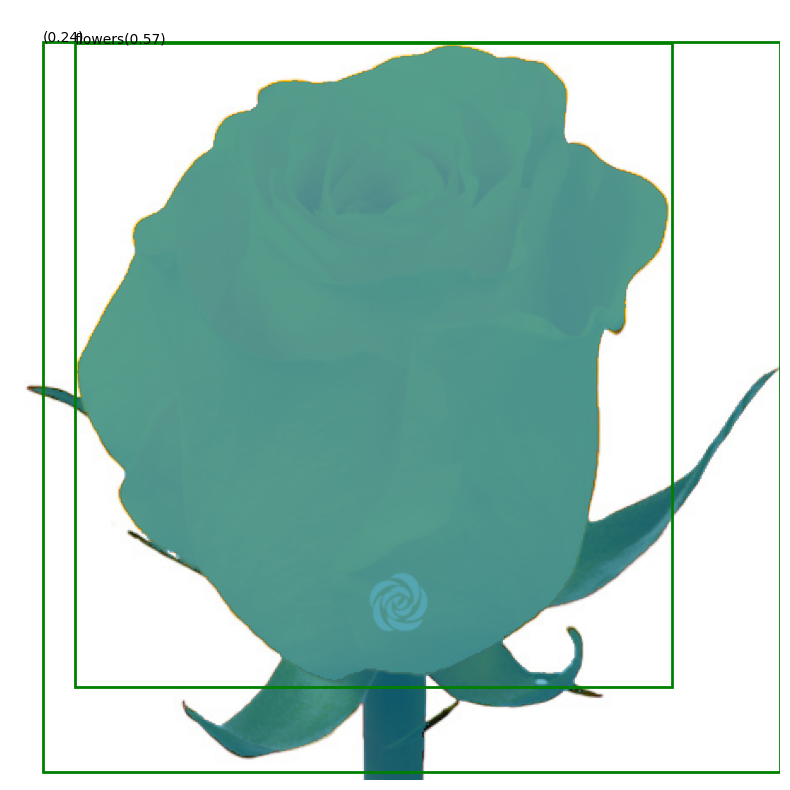

0 flowers
[{'supercategory': None, 'id': 0, 'name': '_background_'}, {'supercategory': None, 'id': 1, 'name': 'flowers'}]
2/5 Image: 000000000002.jpg


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


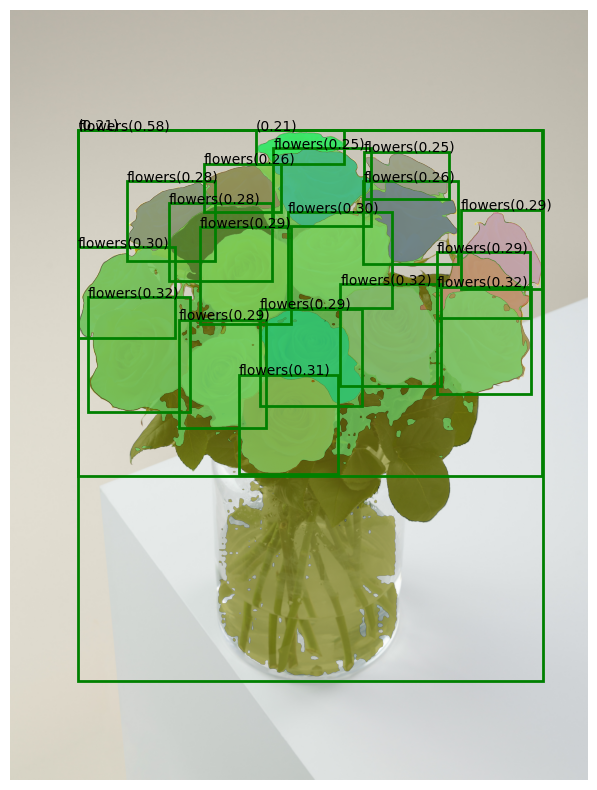

0 flowers
[{'supercategory': None, 'id': 0, 'name': '_background_'}, {'supercategory': None, 'id': 1, 'name': 'flowers'}]
3/5 Image: yolomask_format.txt
yolomask_format.txt no es un archivo .jpg. Saltando esta imagen.
4/5 Image: 000000000003.jpg


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


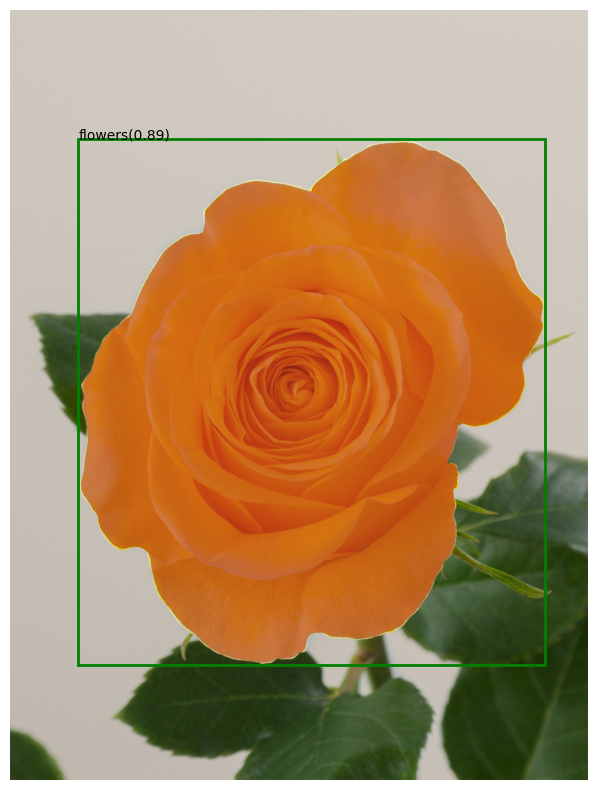

0 flowers
[{'supercategory': None, 'id': 0, 'name': '_background_'}, {'supercategory': None, 'id': 1, 'name': 'flowers'}]
5/5 Image: BBOX_yolo.txt
BBOX_yolo.txt no es un archivo .jpg. Saltando esta imagen.


In [ ]:
cont = 1
for image_name in image_names:

    print(f"{cont}/{len(image_names)} Image: {image_name}")
    cont += 1

    base_name = os.path.splitext(image_name)[0]
    file_name = f'{base_name}.json'

    # Verificar si el archivo JSON ya existe
    if os.path.exists(file_name):
        continue

    if not image_name.lower().endswith('.jpg'):
        print(f"{image_name} no es un archivo .jpg. Saltando esta imagen.")
        continue
    TEXT_PROMPT = "flowers"
    BOX_TRESHOLD = 0.20
    TEXT_TRESHOLD = 0.25

    image_pil, image = load_image(image_name)

    # run grounding dino model
    boxes_filt, pred_phrases = get_grounding_output(
        groundingdino_model, image, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD, device=device
    )

    # set image
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_predictor.set_image(image)

    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

    masks, _, _ = sam_predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes = transformed_boxes.to(device),
        multimask_output = False,
    )

    for i, mask in enumerate(masks):
        binary_mask = mask.cpu().squeeze().numpy().astype(np.uint8)

        # Find the contours of the mask
        contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv2.contourArea)

        # Get the new bounding box
        bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

        # Get the segmentation mask for object
        segmentation = largest_contour.flatten().tolist()

        # Write bounding boxes to file in YOLO format
        with open('BBOX_yolo.txt', 'w') as f:
            for contour in contours:
                # Get the bounding box coordinates of the contour
                x, y, w, h = cv2.boundingRect(contour)
                # Convert the coordinates to YOLO format and write to file
                f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
                f.write('\n')

        mask=segmentation

        # load the image
        #width, height = image_path.size
        img = Image.open(image_name)
        width, height = img.size

        # convert mask to numpy array of shape (N,2)
        mask = np.array(mask).reshape(-1,2)

        # normalize the pixel coordinates
        mask_norm = mask / np.array([width, height])

        # compute the bounding box
        xmin, ymin = mask_norm.min(axis=0)
        xmax, ymax = mask_norm.max(axis=0)
        bbox_norm = np.array([xmin, ymin, xmax, ymax])

        # concatenate bbox and mask to obtain YOLO format
        yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

        # compute the bounding box
        # write the yolo values to a text file
        with open('yolomask_format.txt', 'w') as f:
            for val in yolo:
                f.write("{:.6f} ".format(val))
            f.write('\n')

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    for box, label in zip(boxes_filt, pred_phrases):
        show_box(box.numpy(), plt.gca(), label)
    plt.axis('off')
    plt.show()

    CAT_ID = {'flowers': 1}
    IOU_THRESHOLD = 0.8

    # COCO dict
    coco_annotation = {"images":[], "annotations":[], "categories":[], "color":[]}

    # Set defauly color values
    coco_annotation["color"].append({"id":0, "name":"Amarillo"})
    coco_annotation["color"].append({"id":1, "name":"Blanco"})
    coco_annotation["color"].append({"id":2, "name":"Crema"})
    coco_annotation["color"].append({"id":3, "name":"Durazno"})
    coco_annotation["color"].append({"id":4, "name":"Fucsia"})
    coco_annotation["color"].append({"id":5, "name":"Lavanda"})
    coco_annotation["color"].append({"id":6, "name":"Naranja"})
    coco_annotation["color"].append({"id":7, "name":"Rojo"})
    coco_annotation["color"].append({"id":8, "name":"Rosado"})
    coco_annotation["color"].append({"id":9, "name":"Verde"})

    # Set dafault categories values
    coco_annotation["categories"].append({"supercategory":None, "id":0, "name":"_background_"})

    for i, category in enumerate(CAT_ID.keys()):
        print(i, category)
        coco_annotation["categories"].append({"supercategory":"Rosa", "id":i+1, "name":category})

    print(coco_annotation["categories"])

    # mask conversion method
    transform = TT.ToPILImage()

    # default values (not directly-effective to model training)
    image_id = 1
    annotation_id = 1
    is_crowd = 0
    registerd_regions = []

    # run iteration for attaching object on 1 image
    for i, (box, label) in enumerate(zip(boxes_filt, pred_phrases)):
        # bbox conversion to tensor --> dict
        bbox = {}
        bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2'] = box[0], box[2], box[1], box[3]

        try:
            category_id = int(CAT_ID[label.split('(')[0]])
        except:
            if not label.split('(')[0]:
                continue  # Skip the current iteration
            else:
                category_id = int(CAT_ID[label.split('(')[0].split(' ')[0]])

        mask = masks[i]

        # mask squeeze & conversion
        squeezed_mask = torch.squeeze(mask, 0)
        squeezed_mask = transform(np.uint8(squeezed_mask.cpu()))

        # To check whether multiple bounding boxes are detected for a single objects
        if IOUcalc(registerd_regions, bbox, IOU_THRESHOLD):
            # add bbox area for IoU calc.
            registerd_regions.append(bbox)
            annotation = create_sub_mask_annotation(np.asarray(squeezed_mask), image_id, category_id, annotation_id, is_crowd)
            coco_annotation["annotations"].append(annotation)
            annotation_id += 1
    colors=[0]
    image_info = create_image_info(image_id, image_name, squeezed_mask.size, colors)
    coco_annotation["images"].append(image_info)

    # Save COCO Annotation
    with open(f'/content/anotations/{base_name}.json', 'w') as outfile:
        json.dump(coco_annotation, outfile)

Se genera un archivo .zip con las anotaciones de las imagenes para ser descargadas.

In [ ]:
import shutil

# Comprimir la carpeta en un archivo ZIP
shutil.make_archive('/content/anotations', 'zip', '/content/anotations')


'/content/anotations.zip'